# Basics of Dask Dataframe

This notebook goes through the basics of using ``dask.dataframe``. We do the following

1. Create a fake dataset
2. Load datafrom csvs
3. Perform some computations
4. Output results to file or as plots

## 1. Create a fake dataset

We create a few fake dataframes, and save them as csvs.

In [1]:
import pandas as pd
import numpy as np
for year in range(2000, 2005):
    idx = pd.date_range(str(year), str(year + 1), freq='d', closed='left')
    pd.DataFrame({'A': np.random.randn(len(idx)), 
                  'B': np.random.randint(len(idx))},
                 index=idx).to_csv('{0}.csv'.format(year), index_label='date')

## 2. Load data from csvs

We can load multiple `csv` files into `dask.dataframe` using the `read_csv` function. This supports [globbing](https://en.wikipedia.org/wiki/Glob_%28programming%29) on filenames, and will sort them alphabetically. This results in a single `dask.dataframe.DataFrame` of all data from 2000 to 2005.

To tell `dask` to use the `'date'` column as the index, we'll also use the `set_index` method. These can be chained, allowing the dataframe to be created in a single line.

In [2]:
import dask.dataframe as dd

df = dd.read_csv('*.csv').set_index('date')
df.head()

,A,B
date,,
2000-01-01,-0.928750,280
2000-01-02,-0.711634,280
2000-01-03,-0.426995,280
2000-01-04,-1.698917,280
2000-01-05,1.901336,280


Dask `DataFrame` objects are partitioned into multiple frames along the index. To see how the dataframe is partitioned, you can look at its `divisions` attribute:

In [3]:
df.divisions

('2000-01-01',
 '2000-12-31',
 '2001-12-31',
 '2003-01-01',
 '2004-01-01',
 '2004-12-31')

## 3. Perform some computations

`dask.dataframe` mirrors the [pandas](http://pandas.pydata.org/) api. We can perform arithmetic, reductions, selections, etc... with the same syntax used by pandas.

The main difference is that we'll need to add a `.compute()` to our final result.

In [4]:
df.A[df.A > 3]

dd.Series<series-index-set-partition--collect-f2f64a639a376601d6c253dc1ca8e4dc.A[elemwise-ab0affb8c9739c38e73d8d01a529faef], divisions=('2000-01-01', '2000-12-31', '2001-12-31', '2003-01-01', '2004-01-01', '2004-12-31')>

Instead of a pandas `Series` object, this returns a dask `Series`. To perform the computation and get a pandas object, one needs to append a call to `compute()`.

In [5]:
df.A[df.A > 3].compute()

date
2001-03-20    3.116674
2004-12-31    3.067005
Name: A, dtype: float64

`dask.dataframe` supports a common subset of the pandas api. For a full list of supported operations, see the [documentation](http://dask.pydata.org/en/latest/dataframe.html). We'll do a few more computations below:

In [6]:
df.B[(df.A > 0) & (df.A < 3)].sum().compute()

106258

In [7]:
df.B.groupby(df.B % 2).count().compute()

B
0    1096
1     731
dtype: int64

## 4. Output results

After doing our heavy computation or data reduction in dask.array we would like to either store our results on disk, or transfer our smaller results to numpy arrays so that we can interact with the rest of the PyData ecosystem.

- Use `.compute()` to create a pandas object
- Use `.to_csv()`, `.to_hdf()` or `.to_castra()` to store to disk
- Depend upon the `__array__` protocol for automatic conversion with other projects

### Use `.compute()` to create a pandas object

As we've already seen, the `.compute()` method performs computation and turns our lazily evaluated dask objects into pandas objects:

In [8]:
x = df.A[df.A > 3]
x.compute()

date
2001-03-20    3.116674
2004-12-31    3.067005
Name: A, dtype: float64

### Store to file

You can store your result to a file using one of the `to_*` methods:

- `to_csv`: writes a csv
- `to_hdf`: writes a hdf5 file using [PyTables](http://www.pytables.org/)
- `to_castra`: writes your data as a [castra](https://github.com/blaze/castra)

In [9]:
res = df[df.A > 0]

In [10]:
res.to_csv('my_data.csv')

### Plot with Matplotlib

Because `dask.dataframe` objects implement the `__array__` protocol they often just work with other libraries in the ecosystem. In the example below we pass a `dd.Series` object directly into a `matplotlib` function.

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

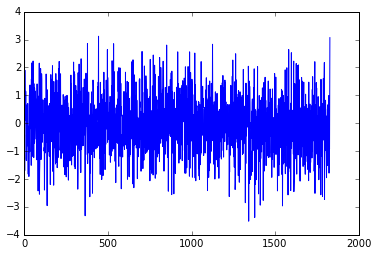

In [12]:
plt.plot(df.A)

Of course, as performing `compute()` returns a `pandas.Series`, you can also just have the `Series` plot itself:

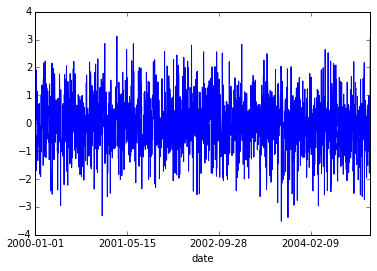

In [13]:
df.A.compute().plot()